In [5]:
from utils.functions import *
from datasets import Dataset

%load_ext autoreload
%autoreload 2

/opt/mamba/envs/putain_de_projet_nlp/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


update saved


Loading data

In [7]:
softmax = torch.load("data//BERT embedding//softmax_n_vs_a")
last_layer = torch.load("data//BERT embedding//last_layer_n_vs_a")
data = pd.read_csv("data//full_dataset.csv", index_col=0)

Getting data of successful attacks only (to move to data_load if interesting)

In [8]:
normal_text = pd.read_csv(r"data/attacks/pwws.csv").original_text
df_attacks = pd.concat(
    [
        pd.read_csv(r"data/attacks/pwws.csv"),
        pd.read_csv(r"data/attacks/bae.csv"),
        pd.read_csv(r"data/attacks/textfooler.csv"),
        pd.read_csv(r"data/attacks/tf-adj.csv"),
    ]
)
skipped_mask = df_attacks.result_type != "Skipped"
df_attacks = df_attacks[skipped_mask].reset_index(drop=True)
success_mask = df_attacks.result_type == "Successful"
success_mask = [*([True] * len(normal_text)), *success_mask]
data = data.copy()[success_mask]
labes = data.label
softmax = softmax[success_mask]
last_layer = last_layer[success_mask]

In [ ]:
last_layer_train = torch.load(r"data//BERT embedding//last_layer_train")
get_maha_score_reduce = lambda outputs: get_mahalanobis_score(
    outputs["last_layer"],
    last_layer_train=last_layer_train,
    num_samples=1,
    reduce_dim=True,
    batch_size = 10000
)

get_maha_score_reduce_linear = lambda outputs: -get_mahalanobis_score(
    outputs["last_layer"],
    last_layer_train=last_layer_train,
    num_samples=1,
    reduce_dim=True,
    kernel = 'linear',
    batch_size = 10000
)

get_maha_score = lambda outputs: -get_mahalanobis_score(
    outputs["last_layer"],
    last_layer_train=last_layer_train,
    num_samples=3,
    reduce_dim=False,
)

get_eucli_score = lambda outputs: get_euclidian_score(
    outputs["last_layer"],
    last_layer_train=last_layer_train,
    preprocess = True
)

In [157]:
outputs = {"softmax": softmax.detach(), "last_layer": last_layer.detach()}
functions = {
    "max_softmax": get_softmax_score,
    "first_to_second": get_1_to_2_score,
    "KL": get_KL_score,
    "Wasserstein": get_Was_score,
    "Mahalanobis": get_maha_score,
    "Euclidian" : get_eucli_score,
    "Mahalanobis rbf" : get_maha_score_reduce,
    "Mahalanobis kPCA linear" : get_maha_score_reduce_linear
            }
labels = data.label

In [ ]:
fpr_threshold = 0.2

Scores = {}
thresholds = {}
threshold = {}
tpr_at_threshold = {}
AUC = {}
AP = {}
tpr = {}
fpr = {}
precision = {}
recall = {}
for method in functions.keys():
    Scores[method] = functions[method](outputs)
    tpr[method], fpr[method], thresholds[method] = roc_curve(
        labels, -Scores[method]
    )
    mask = fpr[method] <= fpr_threshold
    threshold[method] = thresholds[method][mask][-1]
    tpr_at_threshold[method] = tpr[method][mask][-1]
    precision[method], recall[method], _ = precision_recall_curve(
        labels, -Scores[method]
    )
    AUC[method] = auc(fpr[method], tpr[method])
    AP[method] = average_precision_score(labels, -Scores[method])
Results = pd.DataFrame([tpr_at_threshold, AUC], index=["tpr_at_threshold", "AUC"])
# Scores,Thresholds,Results
Results.round(3)

In [60]:
fpr_threshold = 0.2

Scores = {}
thresholds = {}
threshold = {}
tpr_at_threshold = {}
AUC = {}
AP = {}
tpr = {}
fpr = {}
precision = {}
recall = {}
for method in functions.keys():
    Scores[method] = functions[method](outputs)
    tpr[method], fpr[method], thresholds[method] = roc_curve(
        labels, -Scores[method]
    )
    mask = fpr[method] <= fpr_threshold
    threshold[method] = thresholds[method][mask][-1]
    tpr_at_threshold[method] = tpr[method][mask][-1]
    precision[method], recall[method], _ = precision_recall_curve(
        labels, -Scores[method]
    )
    AUC[method] = auc(fpr[method], tpr[method])
    AP[method] = average_precision_score(labels, -Scores[method])
Results = pd.DataFrame([tpr_at_threshold, AUC], index=["tpr_at_threshold", "AUC"])
# Scores,Thresholds,Results
Results.round(3)

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


,max_softmax,first_to_second,KL,Wasserstein,Mahalanobis,Euclidian,Mahalanobis rbf,Mahalanobis kPCA linear
tpr_at_threshold,0.763,0.761,0.765,0.763,0.665,0.661,0.694,0.657
AUC,0.846,0.845,0.847,0.847,0.806,0.798,0.819,0.794


### Graph 1 - ROC Curve

In [88]:
Methods = {'max_softmax' : 'max_softmax', 'first_to_second' : 'FtS', 'KL' : 'KL',
           'Wasserstein' : 'Wasserstein', 'Euclidian' : 'Euclidian', 'Mahalanobis rbf' : 'Mahalanobis'}

max_softmax
first_to_second
KL
Wasserstein
ok
Mahalanobis rbf


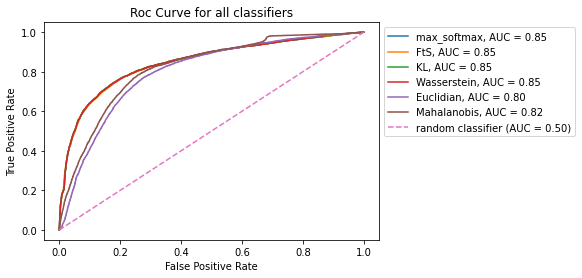

In [206]:
for method in Methods.keys():  # ,'maha']:
    if method == 'Euclidian':
        print('ok')
        plt.plot(fpr[method], tpr[method], label=f"{Methods[method]}, AUC = {0.8}0")
    else:
        print(method)
        plt.plot(fpr[method], tpr[method], label=f"{Methods[method]}, AUC = {AUC[method].round(2)}")
plt.plot(
    np.linspace(0, 1, 2000),
    np.linspace(0, 1, 2000),
    linestyle="dashed",
    label="random classifier (AUC = 0.50)",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc Curve for all classifiers")
plt.legend(bbox_to_anchor=(1,1))
#plt.legend('lower right')
#plt.savefig("graphs/roc_curve_all.jpg" , bbox_inches='tight')

In [133]:
pd.DataFrame([[tpr_at_threshold[method] for method in Methods.keys()]],\
             index=['True Positive Rate'],columns=Methods.values()).round(3)

,max_softmax,FtS,KL,Wasserstein,Euclidian,Mahalanobis
True Positive Rate,0.763,0.761,0.765,0.763,0.661,0.694


### Graph 2 - Confusion Matrix

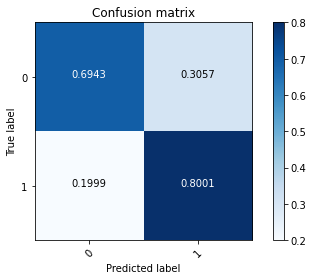

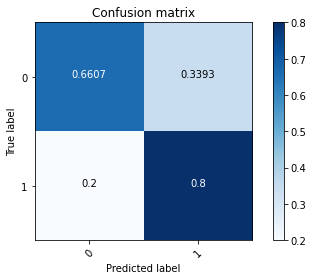

In [246]:
for method in ['Mahalanobis rbf','Euclidian']:
    plot_confusion_matrix(
        confusion_matrix(
            labels, -Scores[method] < threshold[method], normalize="true"
        ).round(4),
        classes=[0, 1],
    )
    plt.show()

### Graph 3 - Distribution of attacks vs not attacks

In [248]:
print('median max softmax for normal texts:',-softmax_scores[softmax_scores['labels']!='attack']['max_softmax'].median())
print('median max softmax for attacks:',-softmax_scores[softmax_scores['labels']=='attack']['max_softmax'].median())

median max softmax for normal texts: 0.9995899796485901
median max softmax for attacks: 0.9573665261268616


/opt/mamba/envs/putain_de_projet_nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


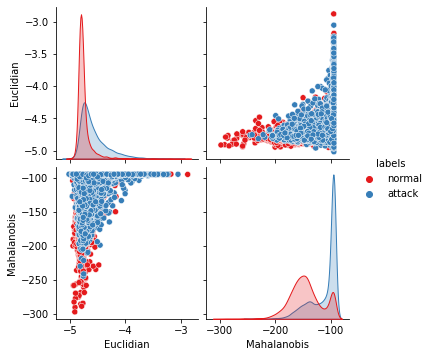

In [249]:
softmax_scores = pd.DataFrame(np.stack(Scores[method][:-3800] for method in Methods.keys()).T\
                              ,columns = Methods.values()).iloc[:,4:]
softmax_scores['labels'] = list(data.label.reset_index(drop=True))[:-3800]
softmax_scores['labels'].replace({0 : 'normal', 1 : 'attack'}, inplace=True)
sns.pairplot(softmax_scores,hue = 'labels', palette='Set1')#,diag_kind='kde')

#### Graph 5 - Boxplot of Attacks vs Normal text Distribution

Text(0.5, 1.0, 'Distribution of max-softmax for attacks vs normal text')

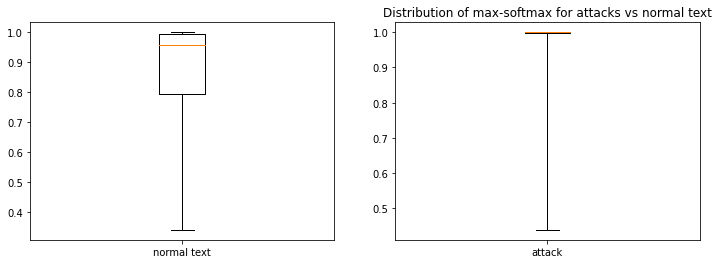

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sorted_softmax = pd.DataFrame(softmax.sort()[0][:, -1])
axs[0].boxplot(sorted_softmax[~mask], labels=["normal text"], whis=1000)
# axs[1].boxplot(sorted_softmax[~mask]);
axs[1].boxplot(sorted_softmax[mask], labels=["attack"], whis=1000)
plt.title("Distribution of max-softmax for attacks vs normal text")
# axs[0].legend()